<a href="https://colab.research.google.com/github/naiaraAM/ML_project_UT/blob/main/Project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Set up enviroment


# Download data


In [1]:
import matplotlib.pyplot as plt
import umap.plot
import numpy as np
import pandas as pd

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import xgboost as xgb

import seaborn as sns

# remove warnings
import warnings
warnings.filterwarnings('ignore')

/home/chispitas/Documents/UT/Machine Learning/Project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chispitas/Documents/UT/Machine Learning/Project/venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/chispitas/Documents/UT/Machine Learning/Project/venv/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  war

In [2]:
!unzip -q playground-series-s4e6.zip -d data
!rm playground-series-s4e6.zip

unzip:  cannot find or open playground-series-s4e6.zip, playground-series-s4e6.zip.zip or playground-series-s4e6.zip.ZIP.
rm: cannot remove 'playground-series-s4e6.zip': No such file or directory


In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print(f"The train data has {train_data.shape[0]} rows and {train_data.shape[1]} columns")
print(f"The test data has {test_data.shape[0]} rows and {test_data.shape[1]} columns")

The train data has 76518 rows and 38 columns
The test data has 51012 rows and 37 columns


<font color='red'>Do your code in the cell bellow your name, so we don't have merge issues. We can merge on friday's meeting</font>


# Data Processing

In [3]:
# We will re-use this code in the future
def plot_class_distribution(y, title="Class Distribution"):

    class_counts = y.value_counts()

    class_counts.plot(kind='bar', color=['skyblue', 'orange', 'red'])
    plt.title(title, fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [4]:
X, Y = train_data.drop(columns=['id', 'Target']), train_data['Target']
X.shape, Y.shape, train_data.shape

((76518, 36), (76518,), (76518, 38))

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, random_state = 111, test_size = 0.20, stratify=Y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((61214, 36), (61214,), (15304, 36), (15304,))

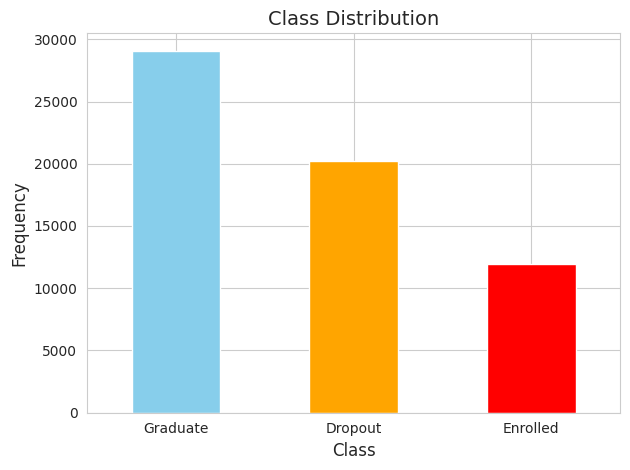

In [6]:
%matplotlib inline

plot_class_distribution(y_train)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train) # normalize data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_data.drop(columns=['id']))

In [10]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

<Axes: >

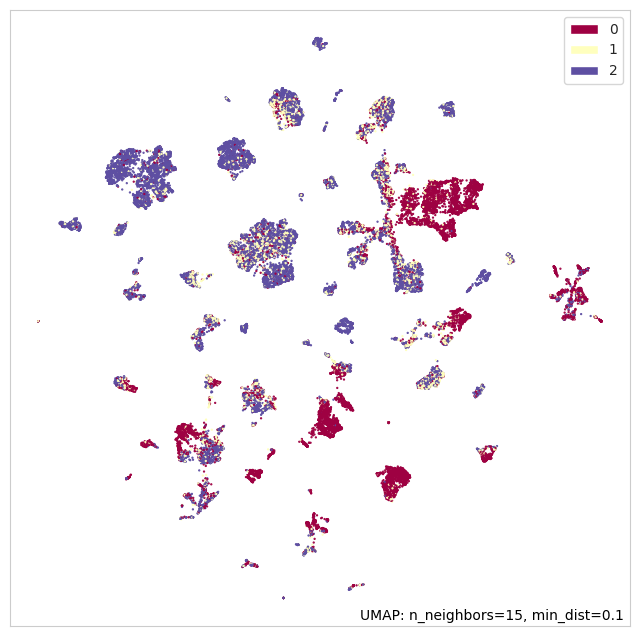

In [11]:
mapper = umap.UMAP().fit(X_scaled)
umap.plot.points(mapper, labels=y_encoded)

## Naiara


In [12]:
# Define class weights
class_weights = {0: 1, 1: 1, 2: 1}

# Create sample weights based on class weights
sample_weight = [class_weights[label] for label in y_encoded]

# Initialize the HistGradientBoosting Classifier
hgb_model = HistGradientBoostingClassifier(
    max_iter=110,              # Equivalent to n_estimators
    learning_rate=0.06,
    max_depth=10,
    min_samples_leaf=20,
    random_state=42
)

# Train the model with sample weights
hgb_model.fit(X_scaled, y_encoded, sample_weight=sample_weight)

HistGradientBoostingClassifier(learning_rate=0.06, max_depth=10, max_iter=110,
                               random_state=42)

In [13]:
# Evaluate the model
accuracy_train = hgb_model.score(X_scaled, y_encoded)
print(f"Train Accuracy: {accuracy_train:.4f}")
print(classification_report(y_encoded, hgb_model.predict(X_scaled)))

Train Accuracy: 0.8504
              precision    recall  f1-score   support

           0       0.92      0.84      0.88     20237
           1       0.70      0.66      0.68     11952
           2       0.87      0.93      0.90     29025

    accuracy                           0.85     61214
   macro avg       0.83      0.81      0.82     61214
weighted avg       0.85      0.85      0.85     61214



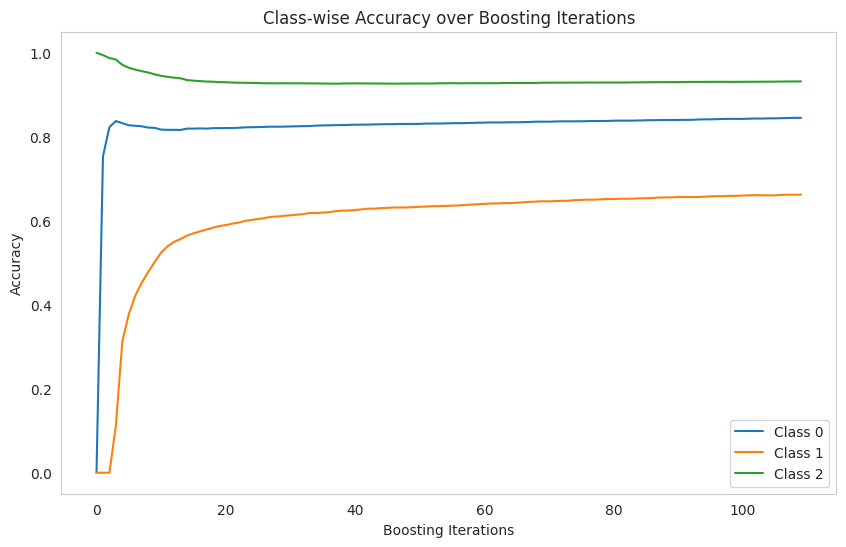

In [14]:
n_classes = len(np.unique(y_encoded))
class_accuracies = np.zeros((hgb_model.max_iter, n_classes))


for i, y_pred in enumerate(hgb_model.staged_predict(X_scaled)):
    for cls in range(n_classes):
        mask = y_encoded == cls
        class_accuracies[i, cls] = accuracy_score(y_encoded[mask], y_pred[mask])

plt.figure(figsize=(10, 6))
for cls in range(n_classes):
    plt.plot(class_accuracies[:, cls], label=f"Class {cls}")

plt.title("Class-wise Accuracy over Boosting Iterations")
plt.xlabel("Boosting Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [15]:
y_val_pred = hgb_model.predict(X_val_scaled)
accuracy_val = accuracy_score(y_val_encoded, y_val_pred)

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.8289
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5059
           1       0.64      0.61      0.63      2988
           2       0.85      0.92      0.88      7257

    accuracy                           0.83     15304
   macro avg       0.80      0.79      0.79     15304
weighted avg       0.83      0.83      0.83     15304



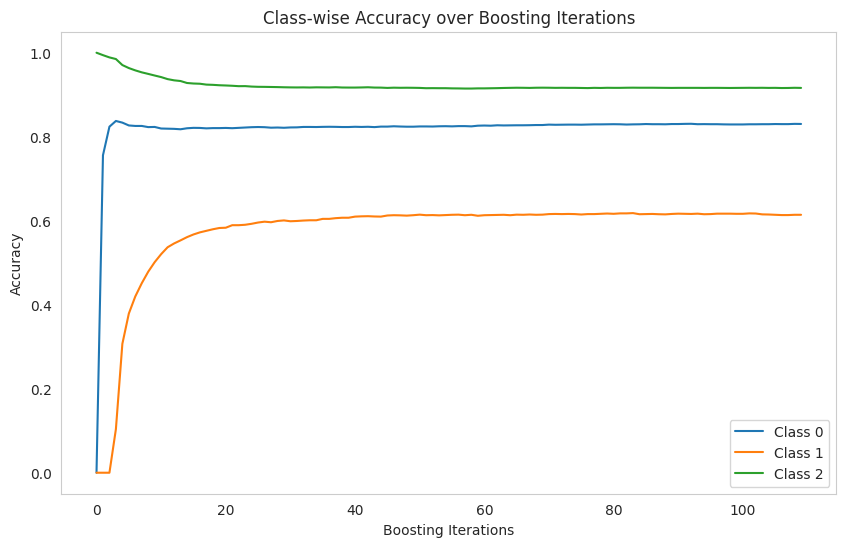

In [16]:
n_classes = len(np.unique(y_val_encoded))
class_accuracies = np.zeros((hgb_model.max_iter, n_classes))

for i, y_pred in enumerate(hgb_model.staged_predict(X_val_scaled)):
    for cls in range(n_classes):
        mask = y_val_encoded == cls
        class_accuracies[i, cls] = accuracy_score(y_val_encoded[mask], y_pred[mask])
        
plt.figure(figsize=(10, 6))
for cls in range(n_classes):
    plt.plot(class_accuracies[:, cls], label=f"Class {cls}")
    
plt.title("Class-wise Accuracy over Boosting Iterations")
plt.xlabel("Boosting Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

<Axes: >

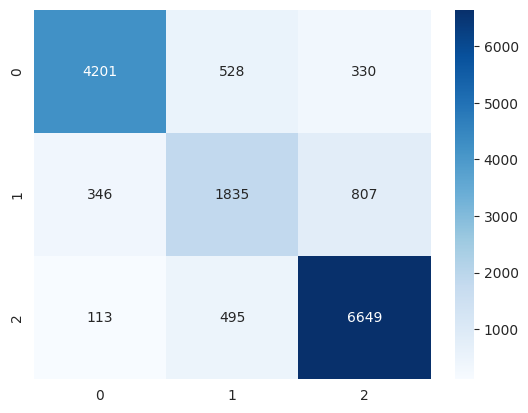

In [17]:
original_labels = label_encoder.inverse_transform(y_val_encoded)
pred_labels = label_encoder.inverse_transform(y_val_pred)

cm = confusion_matrix(original_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [18]:
y_test_gbc = hgb_model.predict(X_test_scaled)
y_test_gbc = label_encoder.inverse_transform(y_test_gbc)

submission = pd.DataFrame(
    {'id': test_data["id"], 'Target': y_test_gbc},
    columns=['id', 'Target']
)
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'


## Juan

In [19]:
train_data.describe(include='all')

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
count,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,...,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518.000000,76518
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Graduate
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36282
mean,38258.500000,1.111934,16.054419,1.644410,9001.286377,0.915314,3.658760,132.378766,1.226600,19.837633,...,0.137053,5.933414,7.234468,4.007201,9.626085,0.062443,11.520340,1.228218,-0.080921,NaN
std,22088.988286,0.441669,16.682337,1.229645,1803.438531,0.278416,8.623774,10.995328,3.392183,15.399456,...,0.933830,1.627182,3.503040,2.772956,5.546035,0.462107,2.653375,1.398816,2.251382,NaN
min,0.000000,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,NaN
25%,19129.250000,1.000000,1.000000,1.000000,9119.000000,1.000000,1.000000,125.000000,1.000000,1.000000,...,0.000000,5.000000,6.000000,1.000000,10.000000,0.000000,9.400000,0.300000,-1.700000,NaN
50%,38258.500000,1.000000,17.000000,1.000000,9254.000000,1.000000,1.000000,133.100000,1.000000,19.000000,...,0.000000,6.000000,7.000000,5.000000,12.142857,0.000000,11.100000,1.400000,0.320000,NaN
75%,57387.750000,1.000000,39.000000,2.000000,9670.000000,1.000000,1.000000,140.000000,1.000000,37.000000,...,0.000000,6.000000,9.000000,6.000000,13.244048,0.000000,12.700000,2.600000,1.790000,NaN


In [20]:
train_data.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [21]:
train_data.dtypes

id                                                  int64
Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees u

In [22]:
train_data.isnull().any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
76513    False
76514    False
76515    False
76516    False
76517    False
Length: 76518, dtype: bool

### Random forest


In [23]:
randomF1000 = RandomForestClassifier(
    n_estimators=1000,
    max_features="sqrt",
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    bootstrap=False,
    criterion="gini",
    random_state=42
)

randomF1000.fit(X_scaled, y_encoded)
randomF1000.score(X_val_scaled, y_val_encoded)

0.8260585467851542

In [24]:
y_val_pred = randomF1000.predict(X_val_scaled)
accuracy_val = accuracy_score(y_val_encoded, y_val_pred)
print(f"Validation Accuracy: {accuracy_val:.4f}")
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.8261
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5059
           1       0.64      0.60      0.62      2988
           2       0.85      0.92      0.88      7257

    accuracy                           0.83     15304
   macro avg       0.80      0.78      0.79     15304
weighted avg       0.83      0.83      0.82     15304



<Axes: >

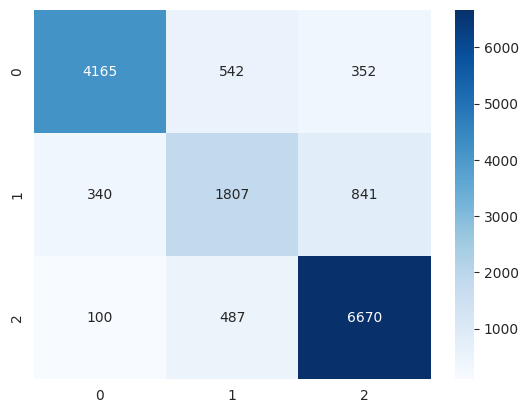

In [25]:
original_labels = label_encoder.inverse_transform(y_val_encoded)
pred_labels = label_encoder.inverse_transform(y_val_pred)

cm = confusion_matrix(original_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [26]:
def submitModel(model, X_test):
    Y_tilda = model.predict(X_test)
    y_decoded = label_encoder.inverse_transform(Y_tilda)
    submission = pd.DataFrame(
        {'id': test_data["id"], 'Target': y_decoded},
        columns = ['id', 'Target'])
    submission.to_csv('submission.csv', index = False)

In [27]:
submitModel(randomF1000, X_test_scaled)

## Fidan


In [28]:
dtrain = xgb.DMatrix(X_scaled, label=y_encoded)
dval = xgb.DMatrix(X_val_scaled, label=y_val_encoded)
dtest = xgb.DMatrix(X_test_scaled)

In [29]:
params = {
    "objective": "multi:softmax", 
    "num_class": len(np.unique(y_encoded)), 
    "eval_metric": "mlogloss",
    "eta": 0.1, 
    "max_depth": 6
}

In [30]:
num_boost_round = 100
early_stopping_rounds = 10
evals = [(dtrain, 'train'), (dval, 'eval')]

In [31]:
xgb_model = xgb.train(params, dtrain, num_boost_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

[0]	train-mlogloss:1.01246	eval-mlogloss:1.01328
[1]	train-mlogloss:0.94044	eval-mlogloss:0.94184
[2]	train-mlogloss:0.87940	eval-mlogloss:0.88135
[3]	train-mlogloss:0.82734	eval-mlogloss:0.83000
[4]	train-mlogloss:0.78226	eval-mlogloss:0.78548
[5]	train-mlogloss:0.74322	eval-mlogloss:0.74717
[6]	train-mlogloss:0.70923	eval-mlogloss:0.71375
[7]	train-mlogloss:0.67937	eval-mlogloss:0.68452
[8]	train-mlogloss:0.65304	eval-mlogloss:0.65875
[9]	train-mlogloss:0.62970	eval-mlogloss:0.63600
[10]	train-mlogloss:0.60919	eval-mlogloss:0.61595
[11]	train-mlogloss:0.59101	eval-mlogloss:0.59835
[12]	train-mlogloss:0.57503	eval-mlogloss:0.58290
[13]	train-mlogloss:0.56077	eval-mlogloss:0.56917
[14]	train-mlogloss:0.54808	eval-mlogloss:0.55695
[15]	train-mlogloss:0.53681	eval-mlogloss:0.54614
[16]	train-mlogloss:0.52671	eval-mlogloss:0.53658
[17]	train-mlogloss:0.51755	eval-mlogloss:0.52798
[18]	train-mlogloss:0.50938	eval-mlogloss:0.52033
[19]	train-mlogloss:0.50207	eval-mlogloss:0.51339
[20]	train

In [32]:
y_pred_val = xgb_model.predict(dval)
accuracy = accuracy_score(y_val_encoded, y_pred_val)
print(f"Validation Accuracy: {accuracy:.4f}")
print(classification_report(y_val_encoded, y_pred_val))

Validation Accuracy: 0.8306
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      5059
           1       0.65      0.62      0.63      2988
           2       0.85      0.92      0.88      7257

    accuracy                           0.83     15304
   macro avg       0.80      0.79      0.79     15304
weighted avg       0.83      0.83      0.83     15304



<Axes: >

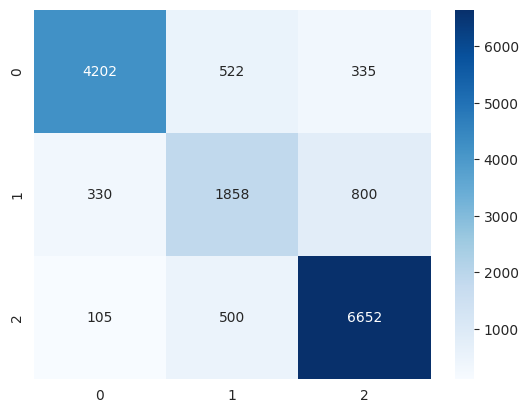

In [33]:
original_labels = label_encoder.inverse_transform(y_val_encoded)
pred_labels = label_encoder.inverse_transform(y_pred_val.astype(int))

cm = confusion_matrix(original_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [34]:
# Predict on test data
y_test_pred = xgb_model.predict(dtest)

predicted_labels = label_encoder.inverse_transform(y_test_pred.astype(int))

def submitModelPredictedLabels(predicted_labels, X_test):
    submission = pd.DataFrame(
        {'id': test_data["id"], 'Target': predicted_labels},
        columns=['id', 'Target']
    )
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")

In [35]:
submitModelPredictedLabels(predicted_labels, test_data)

Submission file saved as 'submission.csv'


# Ensemble model

In [36]:
ensemble = pd.DataFrame()
ensemble["model1"] = hgb_model.predict(X_test_scaled)
ensemble["model2"] = randomF1000.predict(X_test_scaled)
ensemble["model3"] = xgb_model.predict(dtest)

In [37]:
ensemble['ensemble'] = ensemble[["model1", "model2", "model3"]].mode(axis=1)[0]
ensemble['ensemble'] = ensemble['ensemble'].astype(int)
# decode the obtained labels
ensemble['ensemble'] = label_encoder.inverse_transform(ensemble['ensemble'])
print(ensemble['ensemble'].head())

0     Dropout
1    Graduate
2    Graduate
3    Enrolled
4    Enrolled
Name: ensemble, dtype: object


In [38]:
def submitModelPredictedLabels(predicted_labels):
    submission = pd.DataFrame(
        {'id': test_data["id"], 'Target': predicted_labels},
        columns=['id', 'Target']
    )
    submission.to_csv('submission.csv', index=False)
    print("Submission file saved as 'submission.csv'")

In [39]:
submitModelPredictedLabels(ensemble['ensemble'])

Submission file saved as 'submission.csv'
